<a href="https://colab.research.google.com/github/tahamsi/computer-vision/blob/main/generative-models/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/tahamsi/computer-vision)

#Variational Autoencoder (VAE)

VAE is a probabilistic extension of the traditional autoencoder, which compresses high-dimensional input data into a smaller representation. Unlike standard autoencoders that map inputs to fixed latent vectors, VAEs encode inputs into parameters of a probability distribution, typically the mean and variance of a `Gaussian`. This approach results in a continuous, structured latent space, facilitating tasks like image generation ([datacamp](https://www.datacamp.com/tutorial/variational-autoencoders?utm_source=chatgpt.com)).

Autoencoders are a type of neural network designed to learn efficient data representations, primarily for dimensionality reduction or feature learning. They consist of two main components:

* The Encoder: Compresses the input data into a lower-dimensional latent space.
* The Decoder: Reconstructs the original data from this compressed representation.
The primary objective of autoencoders is to minimize the difference between the input and the reconstructed output, thereby learning a compact representation of the data.

In the literature, these networks are also referred to as inference/reconstruction and generative models, respectively.

**VAEs** extend the traditional autoencoder framework by introducing probabilistic elements into the encoding process. While standard autoencoders map inputs to fixed latent representations, VAEs adopt a probabilistic approach, where the encoder outputs a distribution over the latent space, typically modeled as a multivariate Gaussian. During the decoding process, VAEs sample from this distribution, enabling the generation of new data instances.

The key innovation of VAEs lies in their ability to learn a structured, continuous latent space. This is particularly valuable for generative modeling, where the goal is not only to compress data but also to generate new data samples that resemble the original dataset.

# Encoders

In a Variational Autoencoder, the **encoder** is a neural network that maps input data ($x$) to the latent space ($z$). Unlike traditional autoencoders, which map inputs to a single fixed point in the latent space, the encoder in a VAE produces the parameters of a probability distribution, typically the mean ($\mu$) and variance ($σ^2$) of a `Gaussian` distribution. This design allows the VAE to model the uncertainty and variability in the data, making it particularly effective for representing complex data distributions.

Latent Space: A lower-dimensional space where the input data is represented. Instead of mapping data to fixed points, VAEs map data to a probability distribution in this latent space.

So, the encoder maps the input $x$ to parameters $\mu(x)$ and $σ(x)$, defining the approximate posterior: $q(z|x) = \mathcal{N}(\mu, \sigma^2)$.

# Decoders
Decoder defines the conditional distribution of the observation $p(\hat{x}∣z)$, which takes a latent sample $z$ as input and produces the parameters for the conditional distribution of the observation. This is another neural network, is responsible for reconstructing the original data from the latent space representation. Given a sample from the latent space distribution, the decoder generates an output that closely approximates the original input data. This framework enables the VAE to generate new data instances by sampling from the learned latent distribution.

The decoder reconstructs $\hat{x}$ by sampling $z$ from $q(z∣x)$ and estimating $p(\hat{x}∣z)$.

##Reparametrisation Trick

To generate a sample $z$ for the decoder during training, you sample from the latent distribution defined by the parameters output by the encoder, given an input observation $x$. However, this sampling operation introduces a bottleneck, as backpropagation cannot directly propagate gradients through a random sampling process.

Instead of sampling $z$ directly, it expresses $z$ as:
$$z =\mu(x) + σ(x) \cdot ϵ, \quad ϵ \sim \mathcal{N}(0, I)$$

This makes $z$ a deterministic function of $\mu$, $σ$, and $ϵ$, enabling backpropagation during training.

##The process flow can be summarized as follows:

* The input data $x$ is passed through the encoder, which outputs the parameters mean ($\mu$) and variance ($σ^2$) of the latent space distribution $q(z∣x)$.
* Latent variables $z$ are sampled from the distribution $q(z∣x)$ using techniques such as the `reparameterization` trick.
* The sampled $z$ is input into the decoder, which generates the reconstructed data $\hat{x}$, aiming to closely match the original input $x$.

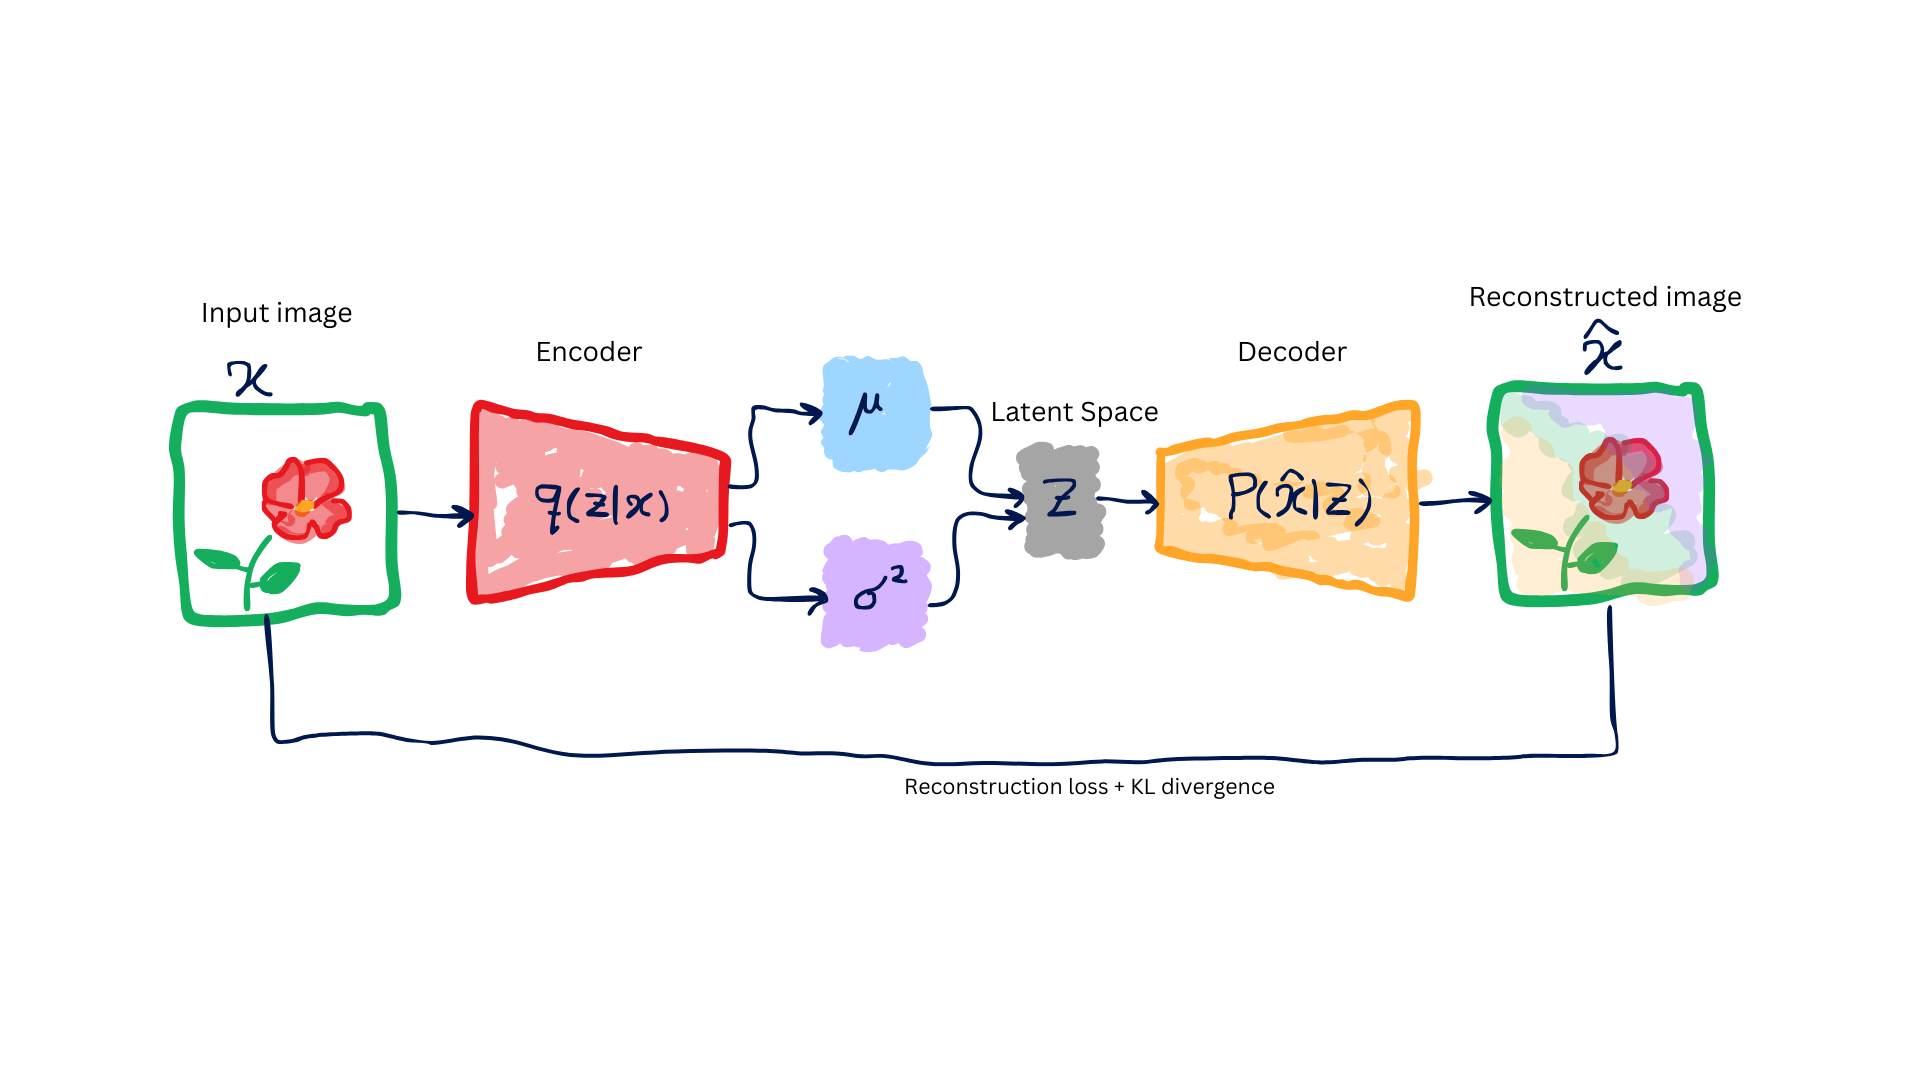

##Objective
VAEs aim to maximize the likelihood of the observed data $x$ while ensuring that the latent space $z$ is meaningful. To achieve this, they use the **Evidence Lower Bound (ELBO)**, which is a simplified approximation of the data likelihood:
$$ \text{ELBO} = \mathbb{E}_{q(z \mid x)} [\log p(x \mid z)] - D_{\text{KL}}(q(z \mid x) \| p(z)) $$

* $\mathbb{E}_{q(z \mid x)} [\log p(x \mid z)]$ or the recunstruction loss, measures how well the reconstructed data matches the input.
* $D_{\text{KL}}(q(z \mid x) \| p(z))$ or KL Divergence, ensures the latent space $z$ aligns with a predefined prior distribution $p(z)$, often a standard normal $\mathcal{N}(0, I)$.


##Training
* The encoder computes $\mu$ and $σ$ for each input $x$.
* The latent variable $z$ is sampled using the reparameterization trick.
* The decoder reconstructs $x$ from $z$.
* The model optimizes the **ELBO** by minimizing the reconstruction loss and the KL divergence.

##Applications

###Generative Modeling
A key strength of VAEs lies in their ability to generate new data samples that are similar to, but not exact replicas of, the training data. For example, in image synthesis, VAEs can create unique images resembling the training set, making them valuable for applications such as generating artwork, realistic faces, or innovative designs in fields like fashion and architecture.

###Anomaly Detection
By learning the distribution of normal data, VAEs can identify deviations from this distribution as anomalies. This capability is especially useful in areas such as fraud detection, network security, and predictive maintenance, where spotting outliers is critical.

###Data Imputation and Denoising
VAEs excel at reconstructing data with missing or noisy parts. By sampling from the learned latent distribution, they can predict and fill in missing values or remove noise from corrupted data. This makes them particularly useful in applications like medical imaging, where accurate reconstruction is vital, or in restoring degraded audio and visual content.

###Semi-Supervised Learning
In scenarios with limited labeled data, VAEs can enhance classifier performance by leveraging their latent space to capture underlying data structures. This helps improve learning efficiency and accuracy in semi-supervised learning tasks.

###Latent Space Manipulation
VAEs offer a structured and continuous latent space that can be directly manipulated for various applications. For example, in image editing, specific features such as lighting or facial expressions can be adjusted by traversing the latent space. This makes VAEs highly valuable in creative industries for tasks like refining and enhancing images or videos.

##Implementation

###Before you start
Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit -> Notebook settings -> Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

###Importing Required Libraries
This block imports the necessary libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
display.clear_output()

###Encoder Class Definition
The Encoder class defines the encoder network:

* It takes an input and passes it through a fully connected layer with `ReLU` activation.
* Then it outputs `mu` (mean) and `logvar` (log variance), which define the distribution over the `latent` space.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

###Decoder Class Definition
The Decoder class defines the decoder network:

* It takes latent variables `z` and passes it through two fully connected (`Dense`) layers, the second of which uses a `sigmoid` activation to reconstruct the original input.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        x_hat = torch.sigmoid(self.fc2(h))
        return x_hat

###Variational Autoencoder Class
The VAE class combines both the encoder and decoder:

* It reparameterizes `mu` and `logvar` to sample `z` (the latent space).
* It uses the sampled `z` to reconstruct the input.

####Reparameterization Trick
The reparameterize function uses the reparameterization trick to sample from the latent space without compromising backpropagation. The `mu` and `logvar` are used to generate latent variable samples.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

###VAE Loss Function
The vae_loss function combines:

* **Reconstruction Loss**: Measures how well the reconstructed input matches the original.
* **KL Divergence**: Measures the divergence between the learned latent variable distribution and the prior (a normal distribution).

In [ ]:
def vae_loss(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_divergence

In [ ]:
# Hyperparameters
input_dim = 784
hidden_dim = 400
latent_dim = 20
lr = 1e-3
batch_size = 128
epochs = 20
# Data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
display.clear_output()

###Training the VAE
The training loop involves:

* Loading and pre-processing the MNIST dataset.
* Computing the loss and apply the gradients using the optimizer.
* Training for a specified number of epochs and batches.

In [ ]:
# Model, optimizer
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=lr)
# Training loop
vae.train()
loss_=[]
for epoch in range(epochs):
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, input_dim)
        optimizer.zero_grad()
        x_hat, mu, logvar = vae(x)
        loss = vae_loss(x, x_hat, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}")
    loss_.append(train_loss / len(train_loader.dataset))
plt.plot(loss_, label='loss')
plt.legend()

###Generating New Samples from the VAE

In [ ]:
# visualizing reconstructed outputs
vae.eval()
with torch.no_grad():
    x, _ = next(iter(train_loader))
    x = x.view(-1, input_dim)
    x_hat, _, _ = vae(x)
    x = x.view(-1, 28, 28)
    x_hat = x_hat.view(-1, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axs[i].imshow(x[i].cpu().numpy(), cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Original Samples', fontsize=14, color='red'),
    plt.show()

    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axs[i].imshow(x_hat[i].cpu().numpy(), cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Recunstructed Samples', fontsize=14, color='green')
    plt.show()

#visualizing generated samples
with torch.no_grad():
    z = torch.randn(10, latent_dim)
    sample = vae.decoder(z)
    sample = sample.view(-1, 28, 28)

    fig, axs = plt.subplots(1, 10, figsize=(15, 2))
    for i in range(10):
        axs[i].imshow(sample[i].cpu().numpy(), cmap='gray')
        axs[i].axis('off')
    fig.suptitle('Generated Samples', fontsize=14, color='blue')
    plt.show()